<a href="https://colab.research.google.com/github/Meitarani-Rezki-Handayani/cnn-kucing-anjing/blob/main/klasifikasi_kucing_dan_anjing_cnn_m3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir /content/cnd

In [3]:
cp /content/drive/MyDrive/deeplearning/dogs-vs-cats.zip /content/cnd

In [ ]:
!unzip /content/cnd/dogs-vs-cats.zip -d /content/cnd

In [ ]:
!unzip /content/cnd/test1.zip -d /content/cnd

In [ ]:
!unzip /content/cnd/train.zip -d /content/cnd

In [17]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.12.0


In [18]:
TRAIN_DIR = "/content/cnd/train"
TEST_DIR = "/content/cnd/test1"
TRAIN_SIZE = len([name for name in os.listdir(TRAIN_DIR)])
TEST_SIZE = len([name for name in os.listdir(TEST_DIR)])
print("Number of training images:", TRAIN_SIZE)
print("Number of test images:", TEST_SIZE)
VALID_FRACTION = 0.2
BATCH_SIZE = 100
EPOCHS = 50
IMAGE_WIDTH = IMAGE_HEIGHT = 150
train_filenames = os.listdir(TRAIN_DIR)
train_labels = []
for filename in train_filenames:
    label = filename.split('.')[0]
    train_labels.append(label)

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})
train_df, valid_df = train_test_split(train_df, test_size=VALID_FRACTION)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )
valid_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df, 
    TRAIN_DIR, 
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Number of training images: 25000
Number of test images: 12500
Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])
model.summary()
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    mode='min',
    restore_best_weights=True, 
    verbose=1,
    patience=5)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

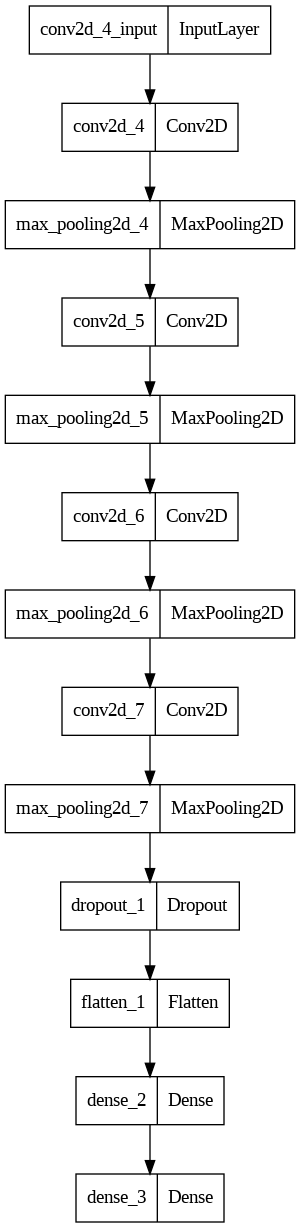

In [20]:
tf.keras.utils.plot_model(model)

In [21]:
%%time
history = model.fit_generator(train_generator,
    validation_data=valid_generator,
    steps_per_epoch=round(TRAIN_SIZE*(1.-VALID_FRACTION)/BATCH_SIZE),
    validation_steps=round(TRAIN_SIZE*VALID_FRACTION/BATCH_SIZE),
    epochs=5,
    callbacks=[es],
    verbose=1)

<timed exec>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
200/200 [==============================] - 848s 4s/step - loss: 0.6800 - accuracy: 0.5664 - val_loss: 0.6793 - val_accuracy: 0.5194
Epoch 2/5
200/200 [==============================] - 855s 4s/step - loss: 0.6364 - accuracy: 0.6396 - val_loss: 0.5808 - val_accuracy: 0.6994
Epoch 3/5
200/200 [==============================] - 849s 4s/step - loss: 0.6149 - accuracy: 0.6636 - val_loss: 0.5789 - val_accuracy: 0.7268
Epoch 4/5
200/200 [==============================] - 827s 4s/step - loss: 0.5795 - accuracy: 0.6921 - val_loss: 0.5898 - val_accuracy: 0.6764
Epoch 5/5
200/200 [==============================] - 826s 4s/step - loss: 0.5570 - accuracy: 0.7138 - val_loss: 0.5168 - val_accuracy: 0.7354
CPU times: user 1h 48min 10s, sys: 10min 11s, total: 1h 58min 21s
Wall time: 1h 11min 3s


Text(0.5, 1.0, 'Training and validation loss')

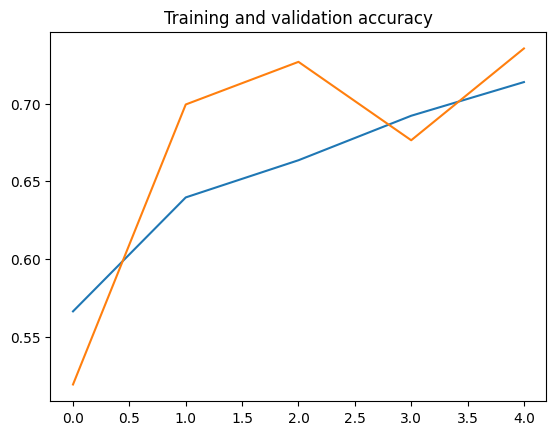

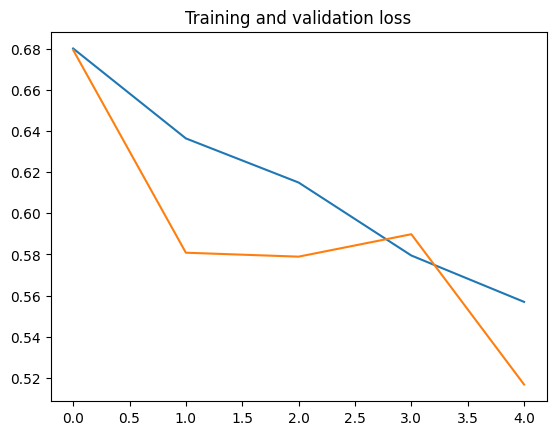

In [22]:
acc = history.history['accuracy']
val_acc = history.history[ 'val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(acc))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [23]:
%%time
test_filenames = os.listdir(TEST_DIR)
test_df = pd.DataFrame({
    'id': test_filenames
})
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    TEST_DIR, 
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)
yhat = model.predict_generator(test_generator, steps=np.ceil(TEST_SIZE/BATCH_SIZE))

Found 12500 validated image filenames.


<timed exec>:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


CPU times: user 3min 28s, sys: 30.9 s, total: 3min 59s
Wall time: 3min 22s


In [24]:
yhat = [1 if y > 0.5 else 0 for y in yhat]
test_df['label'] = yhat
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['label'] = test_df['label'].replace(label_map)
test_df['label'] = test_df['label'].replace({ 'dog': 1, 'cat': 0 })
test_df.to_csv('submission.csv', index=False)

In [25]:
test_df.head()

,id,label
0,12437.jpg,1
1,2288.jpg,0
2,2872.jpg,0
3,5828.jpg,1
4,1040.jpg,1
